In [1]:
pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 3.4MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.models import load_model
import numpy as np
import tensorflow_model_optimization as tfmot
import keras.datasets as dataset
import matplotlib.pyplot as plt
import tempfile
import pickle as pk

Mounted at /content/gdrive


In [3]:
# load and preprocess dataset
cifar = dataset.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
num_classes = 10
train_labels = np_utils.to_categorical(train_labels,num_classes)
test_labels = np_utils.to_categorical(test_labels,num_classes)

# load model
dir_name = '/content/gdrive/My Drive/Fall20/10617_IDL/Project/results/baseline/'
model = load_model(dir_name+'baseline-model.h5')

# Baseline model accuracy
_, model_accuracy = model.evaluate(test_images, test_labels, verbose=0)

170500096/170498071 [==============================] - 2s 0us/step


In [4]:
def build_pruned_model(batch_size,epochs,fin_sp,beg_sp):

  end_step = (train_images.shape[0] // batch_size) * epochs

  # pruning schedule
  pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=beg_sp,
                                                                final_sparsity=fin_sp,
                                                                begin_step=0,
                                                                end_step=end_step)}

  model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
  model_for_pruning.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
  
  return model_for_pruning

def NNZ(weights):
  zeroCount = 0
  for ele in weights:
    if ele != 0.0:
      zeroCount += 1

  return zeroCount

In [5]:
# Build model
batch_size = 32
epochs = 50
beg_sp = 0.50 # begin_sparsity
fin_sp = 0.50 # final_sparsity -- ALWAYS ENTER THE VALUE WITH 2 DECIMAL POINTS
pruned_model = build_pruned_model(batch_size,epochs,fin_sp,beg_sp)
print(pruned_model.summary())

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 32, 32, 32)        1762      
_________________________________________________________________
prune_low_magnitude_activati (None, 32, 32, 32)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 30, 30, 32)        18466     
_________________________________________________________________
prune_low_magnitude_activati (None, 30, 30, 32)        1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 15, 15, 32)        1         
_________________________________________________________________
prune_low_magnitude_dropout  (None, 15, 15, 32)        1         
_________________________________________________

In [6]:
# Fit model
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
pruned_history = pruned_model.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, 
                  validation_data=(test_images,test_labels),
                  callbacks=callbacks)

Epoch 1/50
   1/1563 [..............................] - ETA: 0s - loss: 1.5570 - accuracy: 0.5938WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1563/1563 [==============================] - 26s 17ms/step - loss: 0.4194 - accuracy: 0.8546 - val_loss: 0.7214 - val_accuracy: 0.7896
Epoch 2/50
1563/1563 [==============================] - 27s 17ms/step - loss: 0.3724 - accuracy: 0.8702 - val_loss: 0.6892 - val_accuracy: 0.8011
Epoch 3/50
1563/1563 [==============================] - 26s 17ms/step - loss: 0.3534 - accuracy: 0.8775 - val_loss: 0.6982 - val_accuracy: 0.7989
Epoch 4/50
1563/1563 [==============================] - 26s 17ms/step - loss: 0.3502 - accuracy: 0.8780 - val_loss: 0.7056 - val_accuracy: 0.8019
Epoch 5/50
1563/1563 [==============================

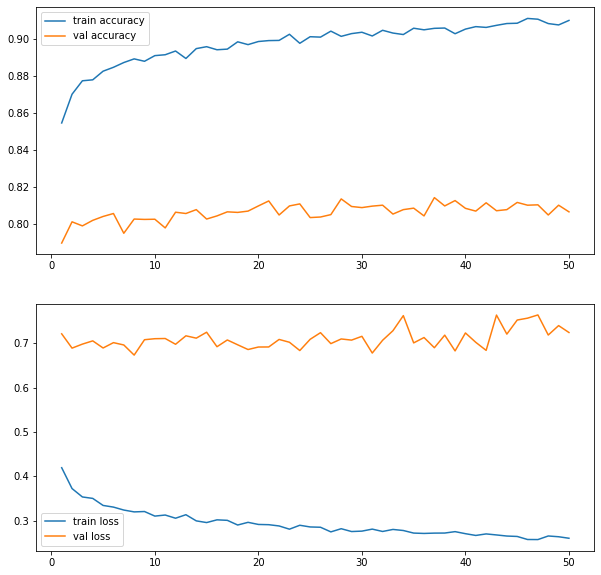

In [7]:
# Plots
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(np.arange(1,len(pruned_history.history['accuracy'])+1),pruned_history.history['accuracy'],label='train accuracy')
plt.plot(np.arange(1,len(pruned_history.history['val_accuracy'])+1),pruned_history.history['val_accuracy'],label='val accuracy')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.arange(1,len(pruned_history.history['loss'])+1),pruned_history.history['loss'],label='train loss')
plt.plot(np.arange(1,len(pruned_history.history['val_loss'])+1),pruned_history.history['val_loss'],label='val loss')
_=plt.legend()

In [8]:
# strip the pruned model to get the final model
pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
print(pruned_model.summary())

pruned_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [9]:
_, pruned_model_accuracy = pruned_model.evaluate(test_images, test_labels, verbose=0)

print('Pruned test accuracy:', pruned_model_accuracy)
print('Baseline test accuracy:', model_accuracy)

Pruned test accuracy: 0.8065000176429749
Baseline test accuracy: 0.792900025844574


In [10]:
folder_name = str(int(fin_sp*100))
dir_name = '/content/gdrive/My Drive/Fall20/10617_IDL/Project/results/CIFAR10/sparse-{d}/'.format(d=folder_name)

# save model
fname = dir_name+'pruned-model-{d}.h5'.format(d=folder_name)
pruned_model.save(fname)

# save logdir
fname = 'log_dir-{d}.pkl'.format(d=folder_name)
with open(dir_name+fname,'wb') as f:
  pk.dump(logdir,f)
f.close()

# save metrics
metric = (pruned_history.history['accuracy'],pruned_history.history['val_accuracy'],
          pruned_history.history['loss'],pruned_history.history['val_loss'])
fname = 'metric-{d}.pkl'.format(d=folder_name)
with open(dir_name+fname,'wb') as f:
  pk.dump(metric,f)
f.close()

In [11]:
# Get the number of non-zeros params
allWeights = np.array([1],dtype=float)
for weight in pruned_model.get_weights():
  allWeights = np.concatenate((allWeights,weight.flatten()))
nnz = NNZ(allWeights[1:])
print("Number of Non-zero Params: ", nnz)
print("Sparsity - (50.00-{d})%".format(d=np.round((1-nnz/allWeights[1:].shape[0])*100,2)))

Number of Non-zero Params:  625786
Sparsity - (50.00-49.97)%
